### Stroke Work - pooled & site-specific Poisson / Robust Poisson / Negative Binomial
<br>Author: Daniel Maina Nderitu<br>
Project: MADIVA

### Import libraries

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from openpyxl.workbook import Workbook

# see all variables
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Set working directory to where your data and outputs will go
os.chdir(r"D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work")
# Ensuring all directories exist
output_dir = r'D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/site_specific/'
os.makedirs(output_dir, exist_ok=True)
os.makedirs("model_output", exist_ok=True)
os.makedirs("visualization", exist_ok=True)

### Load data

In [37]:
# Load your cleaned dataset
df_raw = pd.read_csv("D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/data/cleaned_df.csv")
df = df_raw.copy()
print(df.shape)
# df.head(3)

(47405, 109)


### Data preprocessing

In [39]:
print(df.sex.value_counts())
df['sex_binary'] = df['sex'].replace({1: 0, 2: 1})  # 0 = male, 1 = female
df['bmi_refined'] = pd.to_numeric(df['bmi_refined'], errors='coerce')
# Based on WHO categories
df['bmi_category'] = pd.cut(df['bmi_refined'], 
                            bins=[0, 18.5, 24.9, 29.9, np.inf], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df = pd.get_dummies(df, columns=['bmi_category'], drop_first=True)
# Convert all boolean columns to integers (0/1)
df = df.astype({col: int for col in df.select_dtypes(bool).columns})
print(df.sex_binary.value_counts()) 

sex
2    26556
1    20849
Name: count, dtype: int64
sex_binary
1    26556
0    20849
Name: count, dtype: int64


In [40]:
# Filtering to see if the columns exists
df.filter(like='bmi_category').head()

,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,0,0,0
1,0,1,0
2,0,0,1
3,0,0,0
4,0,0,1


In [41]:
def assign_who_age_group_code(age):
    if pd.isnull(age):
        return 999  # 999 = Missing
    elif age < 15:
        return 1  # Children (0–14)
    elif age < 25:
        return 2  # Youth (15–24)
    elif age < 65:
        return 3  # Adults (25–64)
    else:
        return 4  # Elderly (65+)
# Apply the function to your DataFrame
df["age_group"] = df["age"].apply(assign_who_age_group_code)
# Optional: Map codes to readable labels
age_group_labels = {
    1: "Children (0–14)",
    2: "Youth (15–24)",
    3: "Adults (25–64)",
    4: "Elderly (65+)",
    999: "Missing"
}
df["who_age_group"] = df["age_group"].map(age_group_labels)
# ---------------------------------------------------------------------------
cat_cols = ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived',
            'obese_status_derived', 'diab_status_derived',
            'hiv_status_derived', 'tb_status_derived']
for col in cat_cols:
    df[col] = df[col].astype('category').cat.add_categories('Missing').fillna('Missing')
numeric_cols = ['bmi_refined']
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))
# Exclude irrelevant values
df = df.replace([333, 444, 888, 999], np.nan)
df = df.replace([-333, -444, -888, -999], np.nan)

C:\Users\dmaina\AppData\Local\Temp\ipykernel_25956\3122740068.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["age_group"] = df["age"].apply(assign_who_age_group_code)
C:\Users\dmaina\AppData\Local\Temp\ipykernel_25956\3122740068.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["who_age_group"] = df["age_group"].map(age_group_labels)
C:\Users\dmaina\AppData\Local\Temp\ipykernel_25956\3122740068.py:32: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a fu

In [42]:
# ---------------------------------------------------------------------------
# Handle site variable (ONE-HOT ENCODING)
# ---------------------------------------------------------------------------
# Make sure 'hdss_name' exists and is string
df['hdss_name'] = df['hdss_name'].astype(str)
 
# One-hot encode site (drop one to avoid multicollinearity)
site_dummies = pd.get_dummies(df['hdss_name'], prefix='site', drop_first=True)

# Merge dummy columns into df
df = pd.concat([df, site_dummies], axis=1)
df['site_Nairobi'] = df['site_Nairobi'].astype('category')
# df['site_Agincourt'] = df['site_Agincourt'].astype('category')
print("Site dummy variables created:", list(site_dummies.columns))
# df.head(3)

Site dummy variables created: ['site_Nairobi']


#### To integer type

In [43]:
df.site_Nairobi = df.site_Nairobi.astype(int)

df.bmi_category_Normal = df.bmi_category_Normal.astype(int)
df.bmi_category_Overweight = df.bmi_category_Overweight.astype(int)
df.bmi_category_Obese = df.bmi_category_Obese.astype(int)
# df.hdss_name.value_counts()

### Treatment to ensure we don't inflate incidence

In [44]:
print("Before")
print(df.shape)
df = df.sort_values(['individual_id', 'obs_date'])

# ---------------------------------------------------------------------------
# Sort and prepare time intervals during which a person is at risk
df['age_start'] = df.groupby('individual_id')['age'].shift(0)
df['age_end'] = df.groupby('individual_id')['age'].shift(-1)

# ---------------------------------------------------------------------------
# Define the event (stroke occurrence)
df['stroke_prev'] = df.groupby('individual_id')['stroke_status_derived'].shift(1)
df['event'] = np.where((df['stroke_prev'] == 0) & (df['stroke_status_derived'] == 1), 1, 0)
df['event'] = df['event'].fillna(0)

# ---------------------------------------------------------------------------
# Compute time at risk (calculating person-time for each observation)
df['time_at_risk'] = df['age_end'] - df['age_start']
df['time_at_risk'] = df['time_at_risk'].fillna(1)  # Filling with an average followup of 2 year / we can change this

# ---------------------------------------------------------------------------
# find first event per person  (different from prevalence)
df['cumulative_stroke'] = df.groupby('individual_id')['stroke_status_derived'].cumsum()

# ---------------------------------------------------------------------------
# keep only records before or up to the first stroke
df = df[df['cumulative_stroke'] <= 1]
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# df.head()

Before
(47405, 116)


### Convert to numeric columns, Creating offset

In [45]:
# Convert your numeric columns properly
df = df.apply(pd.to_numeric, errors='coerce')
# Creating offset
df['offset'] = np.log(df['time_at_risk'])

print("after")
print(df.shape)
df.head()

after
(45842, 123)


C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,tb_status_derived_age,obese_status_derived_age,hiv_status_derived_age,sex_binary,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,age_group,who_age_group,site_Nairobi,age_start,age_end,stroke_prev,event,time_at_risk,cumulative_stroke,offset
0,NaN,35,NaN,2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,12.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,99.0,58.0,4.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,27.3,0,NaN,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,0,0,3,NaN,1,35,39.0,NaN,0,4.0,0.0,1.386294
1,NaN,39,NaN,2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,7.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,25.9187,25.9,0,0.0,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,1,0,3,NaN,1,39,NaN,0.0,0,1.0,0.0,0.000000
2,NaN,36,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,7.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,NaN,31.1690,31.2,0,0.0,0.0,36.0,36.0,36.0,36.0,36.0,36.0,0,0,0,1,3,NaN,1,36,NaN,NaN,0,1.0,0.0,0.000000
3,NaN,56,NaN,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,11.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,113.0,73.0,5.8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,27.3,0,NaN,0.0,61.0,56.0,61.0,61.0,61.0,61.0,0,0,0,0,3,NaN,1,56,61.0,NaN,0,5.0,0.0,1.609438
4,NaN,61,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,7.0,7.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Covariates and dealing with infinite values

In [46]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)  # or use .fillna(df.mean()) if numeric

covariates = ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived','bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese' ,'hiv_status_derived', 'tb_status_derived'] #  + list(site_dummies.columns)

# predictors to display in forest plots/compare across sites
key_predictors = ['hpt_status_derived', 'diab_status_derived', 'tb_status_derived', 'site_Nairobi']
# 'sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived','bmi_refined','hiv_status_derived', 'tb_status_derived'
print(df.offset.describe())
df.head()  # Checking something

count    45842.000000
mean         0.394178
std          0.597011
min          0.000000
25%          0.000000
50%          0.000000
75%          1.098612
max          2.079442
Name: offset, dtype: float64


,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,tb_status_derived_age,obese_status_derived_age,hiv_status_derived_age,sex_binary,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,age_group,who_age_group,site_Nairobi,age_start,age_end,stroke_prev,event,time_at_risk,cumulative_stroke,offset
0,0.0,35,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,58.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,27.3,0,0.0,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,0,0,3,0.0,1,35,39.0,0.0,0,4.0,0.0,1.386294
1,0.0,39,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,7.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25.9187,25.9,0,0.0,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,1,0,3,0.0,1,39,0.0,0.0,0,1.0,0.0,0.000000
2,0.0,36,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,7.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,31.1690,31.2,0,0.0,0.0,36.0,36.0,36.0,36.0,36.0,36.0,0,0,0,1,3,0.0,1,36,0.0,0.0,0,1.0,0.0,0.000000
3,0.0,56,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,113.0,73.0,5.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,27.3,0,0.0,0.0,61.0,56.0,61.0,61.0,61.0,61.0,0,0,0,0,3,0.0,1,56,61.0,0.0,0,5.0,0.0,1.609438
4,0.0,61,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,7.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Cleaning & checks (event, time_at_risk, site)

In [47]:
# Ensuring required columns exist
required = ['event', 'time_at_risk', 'hdss_name'] + covariates
missing_cols = [c for c in required if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in df: {missing_cols}")

# dropping rows with non-positive time_at_risk
df = df.copy()
df = df[df['time_at_risk'].notna()]
df = df[df['time_at_risk'] > 0]

# Ensuring hdss_name entries are strings and consistent
df['hdss_name'] = df['hdss_name'].astype(str).str.strip()

# Creating site dummies; Agincourt is the reference site -> drop_first=True will drop first alphabetically by default
# We'll create specifically site_Nairobi and site_Agincourt if needed and ensure Agincourt is reference
sites = df['hdss_name'].unique().tolist()
print("Sites found:", sites)

# create dummies and keep only 'site_Nairobi' as dummy (Agincourt reference)
site_dummies = pd.get_dummies(df['hdss_name'], prefix='site')
# If both created, drop 'site_Agincourt' to make it reference
if 'site_Agincourt' in site_dummies.columns:
    if 'site_Nairobi' not in site_dummies.columns:
        # make sure Nairobi present; handle gracefully if not
        pass
    site_cols = [c for c in site_dummies.columns if c != 'site_Agincourt']
else:
    site_cols = [c for c in site_dummies.columns]  # in case naming differs
# attach to df
df = pd.concat([df, site_dummies], axis=1)

# If site_Nairobi exists and Agincourt exists then site_Agincourt being absent from X implies Agincourt reference
print("Site dummy columns:", [c for c in site_cols if c in df.columns])

Sites found: ['0.0']
Site dummy columns: ['site_0.0']


### Offset for pooled models

In [48]:
# -----------------------------
# 2. Prepare X, y, offset for pooled models
# -----------------------------
# select only covariates that exist in df (defensive)
covariates_present = [c for c in covariates if c in df.columns]
print("Covariates used:", covariates_present)

# pooled model covariates: base covariates + site dummy(s) (we expect site_Nairobi at least)
pooled_covs = covariates_present + [c for c in site_cols if c in df.columns]
X_pooled = df[pooled_covs].copy()
y = df['event'].copy()
offset = np.log(df['time_at_risk'].astype(float))

# convert booleans to int and coerce others to numeric
bool_cols = X_pooled.select_dtypes(include=['bool']).columns.tolist()
for c in bool_cols:
    X_pooled[c] = X_pooled[c].astype(int)

X_pooled = X_pooled.apply(pd.to_numeric, errors='coerce')

# align indices and drop rows with any NA in X,y,offset
mask = X_pooled.notna().all(axis=1) & y.notna() & np.isfinite(offset)
X_pooled = X_pooled.loc[mask]
y_pooled = y.loc[mask]
offset_pooled = offset.loc[mask]

# add constant
X_pooled_const = sm.add_constant(X_pooled, has_constant='add')

print("Pooled dataset rows used:", X_pooled_const.shape[0])

Covariates used: ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived', 'obese_status_derived', 'diab_status_derived', 'bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese', 'hiv_status_derived', 'tb_status_derived']
Pooled dataset rows used: 42445


### Fit pooled models

In [49]:
# -----------------------------
# 3. Fit pooled models
# -----------------------------
print("\nFitting pooled Poisson...")
model_pois = sm.GLM(y_pooled, X_pooled_const, family=sm.families.Poisson(), offset=offset_pooled).fit()
print(model_pois.summary())

print("\nFitting pooled Robust Poisson (HC0)...")
model_robust = sm.GLM(y_pooled, X_pooled_const, family=sm.families.Poisson(), offset=offset_pooled).fit(cov_type='HC0')
print(model_robust.summary())

print("\nFitting pooled Negative Binomial...")
model_nb = sm.GLM(y_pooled, X_pooled_const, family=sm.families.NegativeBinomial(), offset=offset_pooled).fit()
print(model_nb.summary())


Fitting pooled Poisson...
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                42445
Model:                            GLM   Df Residuals:                    42433
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2788.6
Date:                Fri, 24 Oct 2025   Deviance:                       4529.2
Time:                        12:27:25   Pearson chi2:                 6.05e+04
No. Iterations:                    51   Pseudo R-squ. (CS):            0.01030
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                42445
Model:                            GLM   Df Residuals:                    42433
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2789.8
Date:                Fri, 24 Oct 2025   Deviance:                       4126.8
Time:                        12:27:26   Pearson chi2:                 5.81e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.01027
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -3

### Dispersion and model comparison

In [50]:
# -----------------------------
# 4. Dispersion & model comparison
# -----------------------------
def dispersion(model):
    return model.pearson_chi2 / model.df_resid

disp_pois = dispersion(model_pois)
disp_nb = dispersion(model_nb)
print(f"\nPooled Poisson dispersion (Pearson chi2 / df): {disp_pois:.3f}")
print(f"Pooled NB dispersion (Pearson chi2 / df): {disp_nb:.3f}")

comparison = pd.DataFrame({
    'model': ['Poisson', 'RobustPoisson', 'NegBinomial'],
    'AIC': [model_pois.aic, model_robust.aic if hasattr(model_robust, 'aic') else np.nan, model_nb.aic],
    'LogLik': [model_pois.llf, model_robust.llf if hasattr(model_robust, 'llf') else np.nan, model_nb.llf],
    'Dispersion': [disp_pois, np.nan, disp_nb]
})
print("\nModel comparison:\n", comparison)


Pooled Poisson dispersion (Pearson chi2 / df): 1.427
Pooled NB dispersion (Pearson chi2 / df): 1.370

Model comparison:
            model          AIC       LogLik  Dispersion
0        Poisson  5601.226238 -2788.613119    1.426755
1  RobustPoisson  5601.226238 -2788.613119         NaN
2    NegBinomial  5603.614984 -2789.807492    1.369707


### Interaction test
Adding interactions between site_Nairobi and each covariate in covariates present

In [51]:
# -----------------------------
# 5. Interaction test: site x covariate(s)
#    We'll add interactions between site_Nairobi and each covariate in covariates_present
# -----------------------------
# Only create interactions if site_Nairobi exists
site_dummy = 'site_Nairobi' if 'site_Nairobi' in df.columns else None
if site_dummy is None:
    print("Warning: site_Nairobi column not found; skipping interactions.")
else:
    print("\nBuilding pooled model with site interactions (Poisson)...")
    X_int = X_pooled.copy()
    inter_cols = []
    for c in covariates_present:
        inter_name = f"{c}_x_{site_dummy}"
        X_int[inter_name] = X_int[c] * df.loc[X_int.index, site_dummy]
        inter_cols.append(inter_name)
    X_int_const = sm.add_constant(X_int, has_constant='add')
    # align offset and y
    offset_int = offset_pooled.loc[X_int_const.index]
    y_int = y_pooled.loc[X_int_const.index]

    model_int = sm.GLM(y_int, X_int_const, family=sm.families.Poisson(), offset=offset_int).fit()
    print(model_int.summary())

    # LR test comparing base pooled Poisson vs model_int
    llf_base = model_pois.llf
    llf_full = model_int.llf
    df_diff = model_int.df_model - model_pois.df_model
    lr_stat = 2 * (llf_full - llf_base)
    p_lr = 1 - stats.chi2.cdf(lr_stat, df_diff)
    print(f"\nInteraction LR test: chi2={lr_stat:.2f}, df={df_diff}, p={p_lr:.4g}")


Building pooled model with site interactions (Poisson)...
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                42445
Model:                            GLM   Df Residuals:                    42422
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2727.0
Date:                Fri, 24 Oct 2025   Deviance:                       4405.9
Time:                        12:27:28   Pearson chi2:                 5.95e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.01317
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

### Site-specific models (Poisson and NB) and IRR extracts

In [52]:
# -----------------------------
# 6. Site-specific models (Poisson and NB) and extract IRRs
# -----------------------------
site_models = {}
site_results = []
for site in df['hdss_name'].unique():
    dfi = df[df['hdss_name'] == site].copy()
    # ensure positive time at risk and enough rows
    dfi = dfi[dfi['time_at_risk'] > 0]
    n = dfi.shape[0]
    events = dfi['event'].sum()
    print(f"\nSite: {site}  n={n}  events={events}")
    if n < 50 or events < 5:
        print(f"  Skipping site {site} due to small n or few events (n={n}, events={events})")
        continue

    Xi = dfi[covariates_present].copy()
    # booleans->int
    bool_cols_site = Xi.select_dtypes(include=['bool']).columns.tolist()
    for c in bool_cols_site:
        Xi[c] = Xi[c].astype(int)
    Xi = Xi.apply(pd.to_numeric, errors='coerce')

    yi = dfi['event'].copy()
    offi = np.log(dfi['time_at_risk'].astype(float))

    mask_i = Xi.notna().all(axis=1) & yi.notna() & np.isfinite(offi)
    Xi = Xi.loc[mask_i]
    yi = yi.loc[mask_i]
    offi = offi.loc[mask_i]
    Xi_const = sm.add_constant(Xi, has_constant='add')

    try:
        mod_p = sm.GLM(yi, Xi_const, family=sm.families.Poisson(), offset=offi).fit()
        mod_nb = sm.GLM(yi, Xi_const, family=sm.families.NegativeBinomial(), offset=offi).fit()
    except Exception as e:
        print(f"  Models failed for site {site}: {e}")
        continue

    site_models[site] = {'poisson': mod_p, 'nb': mod_nb}

    # extract IRRs and CIs for key covariates
    for mname, m in [('Poisson', mod_p), ('NegBinomial', mod_nb)]:
        res_df = pd.DataFrame({
            'site': site,
            'Model': mname,
            'Variable': m.params.index,
            'coef': m.params.values,
            'se': m.bse,
            'p': m.pvalues,
            'CI_lower': m.conf_int()[0],
            'CI_upper': m.conf_int()[1]
        })
        res_df['IRR'] = np.exp(res_df['coef'])
        res_df['IRR_CI_lower'] = np.exp(res_df['CI_lower'])
        res_df['IRR_CI_upper'] = np.exp(res_df['CI_upper'])
        site_results.append(res_df)

site_results_df = pd.concat(site_results, ignore_index=True)
site_results_df.to_excel(os.path.join(output_dir, 'site_specific_models.xlsx'), index=False)
print("\nSaved site-specific IRRs to Excel.")


Site: 0.0  n=42445  events=524

Saved site-specific IRRs to Excel.


C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### Export pooled model IRRs

In [53]:
# -----------------------------
# 7. Export pooled model IRRs
# -----------------------------
def summarize_model(m, model_name):
    dfm = pd.DataFrame({
        'Variable': m.params.index,
        'coef': m.params.values,
        'se': m.bse,
        'p': m.pvalues,
        'CI_lower': m.conf_int()[0],
        'CI_upper': m.conf_int()[1]
    })
    dfm['IRR'] = np.exp(dfm['coef'])
    dfm['IRR_CI_lower'] = np.exp(dfm['CI_lower'])
    dfm['IRR_CI_upper'] = np.exp(dfm['CI_upper'])
    dfm['Model'] = model_name
    return dfm

pooled_summ = pd.concat([summarize_model(model_pois, 'Poisson'),
                         summarize_model(model_robust, 'RobustPoisson'),
                         summarize_model(model_nb, 'NegBinomial')], ignore_index=True)

pooled_summ.to_excel(os.path.join(output_dir, 'pooled_model_comparison.xlsx'), index=False)
print("Saved pooled model comparison to Excel.")

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Saved pooled model comparison to Excel.


### Forest plot comparing site-specific NB IRRs for key predictors

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


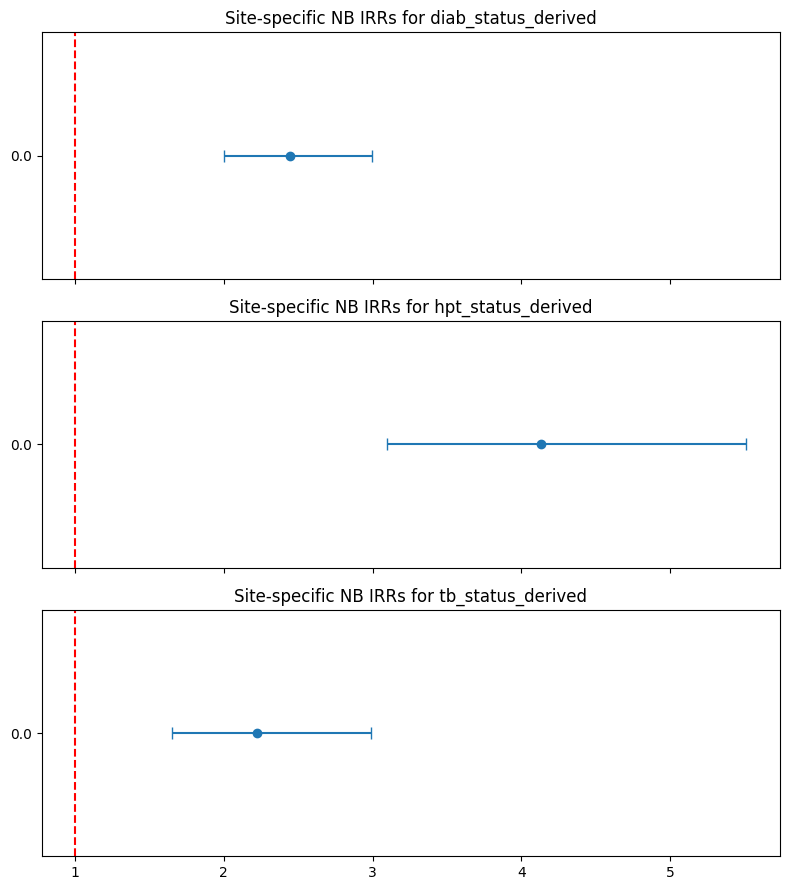

Saved forest plot: D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/site_specific/site_specific_nb_forest.png


In [54]:
# -----------------------------
# 8. Forest plot comparing site-specific NB IRRs for key predictors
# -----------------------------
# pull NB results for key predictors
rows = site_results_df[(site_results_df['Model'] == 'NegBinomial') &
                      (site_results_df['Variable'].isin(key_predictors))].copy()
# pivot for plotting
if not rows.empty:
    # convert IRR columns numeric
    rows['IRR'] = pd.to_numeric(rows['IRR'])
    rows['IRR_CI_lower'] = pd.to_numeric(rows['IRR_CI_lower'])
    rows['IRR_CI_upper'] = pd.to_numeric(rows['IRR_CI_upper'])

    # sort by variable, then site
    rows = rows.sort_values(['Variable', 'site'])
    # plot per predictor in separate subplots
    predictors = rows['Variable'].unique()
    nplots = len(predictors)
    fig, axes = plt.subplots(nplots, 1, figsize=(8, 3 * nplots), sharex=True)
    if nplots == 1:
        axes = [axes]
    for ax, pred in zip(axes, predictors):
        rr = rows[rows['Variable'] == pred].copy()
        y_pos = np.arange(len(rr))
        ax.errorbar(rr['IRR'], y_pos,
                    xerr=[rr['IRR'] - rr['IRR_CI_lower'], rr['IRR_CI_upper'] - rr['IRR']],
                    fmt='o', capsize=4)
        ax.axvline(1, color='red', linestyle='--')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(rr['site'])
        ax.set_title(f'Site-specific NB IRRs for {pred}')
        ax.invert_yaxis()
    plt.tight_layout()
    fig_path = os.path.join(output_dir, 'site_specific_nb_forest.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved forest plot: {fig_path}")
else:
    print("No site-specific NB results found for the requested key predictors.")


### Interpretive output

In [55]:
# -----------------------------
# 9. Short interpretive output (console)
# -----------------------------
print("\n--- Top pooled Negative Binomial IRRs ---")
pooled_nb = pooled_summ[pooled_summ['Model'] == 'NegBinomial'].copy()
pooled_nb = pooled_nb.sort_values('IRR', ascending=False)
print(pooled_nb[['Variable', 'IRR', 'IRR_CI_lower', 'IRR_CI_upper', 'p']].head(15))

# Done
print("\nAll done. Check Excel files and plots in:", output_dir)



--- Top pooled Negative Binomial IRRs ---
                   Variable       IRR  IRR_CI_lower  IRR_CI_upper             p
38                 site_0.0       inf      0.000000           inf  9.474662e-01
35       bmi_category_Obese  8.768370      4.399225     17.476785  6.842170e-10
30       hpt_status_derived  4.132112      3.098006      5.511400  4.706214e-22
32      diab_status_derived  2.447469      2.001598      2.992660  2.708601e-18
37        tb_status_derived  2.221364      1.651299      2.988230  1.329078e-07
33      bmi_category_Normal  2.128174      1.641588      2.758990  1.182749e-08
34  bmi_category_Overweight  1.913454      1.475397      2.481574  9.981039e-07
36       hiv_status_derived  1.203631      0.950023      1.524940  1.247156e-01
29              tobacco_use  0.868628      0.688379      1.096074  2.352698e-01
27               sex_binary  0.681463      0.571684      0.812324  1.875657e-05
28              alcohol_use  0.553584      0.398651      0.768731  4.154932e-